In [ ]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from threading import Thread
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

init_notebook_mode(connected=True)

# download dataset

In [ ]:
# install Kaggle
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chaimabouab","key":"4c9dba2231ee394879b8af8eafc26cdc"}'}

In [ ]:
#Creat a kaggle folder
!mkdir ~/.kaggle
#copy the kaggle.json to folder created
!cp kaggle.json  ~/.kaggle/
#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset


100% 23.1G/23.1G [04:25<00:00, 64.2MB/s]
100% 23.1G/23.1G [04:25<00:00, 93.2MB/s]


In [ ]:
# unzip
!unzip fashion-product-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: fashion-dataset/styles/58128.json  
  inflating: fashion-dataset/styles/58129.json  
  inflating: fashion-dataset/styles/5813.json  
  inflating: fashion-dataset/styles/58131.json  
  inflating: fashion-dataset/styles/58132.json  
  inflating: fashion-dataset/styles/58133.json  
  inflating: fashion-dataset/styles/58135.json  
  inflating: fashion-dataset/styles/58136.json  
  inflating: fashion-dataset/styles/58137.json  
  inflating: fashion-dataset/styles/58138.json  
  inflating: fashion-dataset/styles/58139.json  
  inflating: fashion-dataset/styles/5814.json  
  inflating: fashion-dataset/styles/58140.json  
  inflating: fashion-dataset/styles/58141.json  
  inflating: fashion-dataset/styles/58143.json  
  inflating: fashion-dataset/styles/58144.json  
  inflating: fashion-dataset/styles/58145.json  
  inflating: fashion-dataset/styles/58146.json  
  inflating: fashion-dataset/styles/58147.json  
  inflating: fashion

# Product Recommendations: Visually Similar Content Filtering using KNNs
- A recommender system, or a recommendation system, is a subclass of information filtering system that provide suggestions for items that are most pertinent to a particular user.Typically, the suggestions refer to various decision-making processes, such as what product to purchase, what music to listen to, or what online news to read. Recommender systems are particularly useful when an individual needs to choose an item from a potentially overwhelming number of items that a service may offer.
- Recommender Systems can be broadly classified into 3 types
    - Collaborative Filtering
    - Content-Based Filtering
    - Hybrid
- This notebook will demonstrate the Content-Based filtering, which are based on the description of an item and a profile of the user’s preferred choices. In a content-based recommendation system, features are used to describe the items, besides, a user profile is built to state the type of item this user likes. In other words, the algorithms try to recommend products that are similar to the ones that a user has liked in the past.
- Although we do not have any kind of user profile data, we will use K-Nearest Neighbours algorithms to recommend products which have visually similar features, such as the ones you see in shopping websites **e.g. "Products that are similar to this"**

![image.png](attachment:d5021ea8-8280-437b-9399-ee2b372f8a80.png)

# EDA and Visualization
- Lets first merge the image data and product meta data to get the required dataset
- We will look at some of the categories and subcategories to understand which categories are more dominant

## Images Dataframe

In [ ]:
images_df = pd.read_csv("./fashion-dataset/fashion-dataset/images.csv")

## Product Meta Data Dataframe

In [ ]:
styles_df = pd.read_csv("./fashion-dataset/fashion-dataset/styles.csv", on_bad_lines='skip')

## Create Unique ID in both Dataframes

In [ ]:
images_df['id'] = images_df['filename'].apply(lambda x: x.replace(".jpg","")).astype(int)

In [ ]:
images_df

filename                                               link     id
0      15970.jpg  http://assets.myntassets.com/v1/images/style/p...  15970
1      39386.jpg  http://assets.myntassets.com/v1/images/style/p...  39386
2      59263.jpg  http://assets.myntassets.com/v1/images/style/p...  59263
3      21379.jpg  http://assets.myntassets.com/v1/images/style/p...  21379
4      53759.jpg  http://assets.myntassets.com/v1/images/style/p...  53759
...          ...                                                ...    ...
44441  17036.jpg  http://assets.myntassets.com/v1/images/style/p...  17036
44442   6461.jpg  http://assets.myntassets.com/v1/images/style/p...   6461
44443  18842.jpg  http://assets.myntassets.com/v1/images/style/p...  18842
44444  46694.jpg  http://assets.myntassets.com/v1/images/style/p...  46694
44445  51623.jpg  http://assets.myntassets.com/assets/images/516...  51623

[44446 rows x 3 columns]

## Merging the Two Dataframes

In [ ]:
data = styles_df.merge(images_df,on='id',how='left').reset_index(drop=True)
data['filename'] = data['filename'].apply(lambda x: os.path.join("../input/fashion-product-images-dataset/fashion-dataset/images/",x))

In [ ]:
image_files = os.listdir("./fashion-dataset/fashion-dataset/images")

## Removing Products for which images are not present

In [ ]:
data['file_found'] = data['id'].apply(lambda x: f"{x}.jpg" in image_files)

In [ ]:
data = data[data['file_found']].reset_index(drop=True)

## Final Data

In [ ]:
data.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  \
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt   
1  2012.0  Casual             Peter England Men Party Blue Jeans   
2  2016.0  Casual                       Titan Women Silver Watch   
3  2011.0  Casual  Manchester United Men Solid Black Track Pants   
4  2012.0  Casual                          Puma Men Grey T-shirt   

                                            filename  \
0  ../input/fashion-product-images-dataset/fashio...   
1  ../input/fashion-product-images-dataset/fashio...   
2  ../input/fashion-product-images-dataset/fashio...   
3  ../input/fashion-product-images-dataset/fashio...   
4  ../input/fashion-product-images-dataset/fashio...   

                                                link  file_found  
0  http://assets.myntassets.com/v1/images/style/p...        True  
1  http://assets.myntassets.com/v1/images/style/p...        True  
2  http://assets.myntassets.com/v1/images/style/p...        True  
3  http://assets.myntassets.com/v1/images/style/p...        True  
4  http://assets.myntassets.com/v1/images/style/p...        True

## Checking for Null Values

In [ ]:
data.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
filename                0
link                    0
file_found              0
dtype: int64

## Remove Unneccessary Columns
- As for now we will delete the product display name, but in the future versions of the notebook we will also use the text features

In [ ]:
data.drop(columns=['productDisplayName','link','file_found'],inplace=True)
data

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44414  17036    Men       Footwear       Shoes           Casual Shoes   
44415   6461    Men       Footwear  Flip Flops             Flip Flops   
44416  18842    Men        Apparel     Topwear                Tshirts   
44417  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44418  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44414      White  Summer  2013.0  Casual   
44415        Red  Summer  2011.0  Casual   
44416       Blue    Fall  2011.0  Casual   
44417       Blue  Spring  2017.0  Casual   
44418       Pink  Winter  2016.0  Casual   

                                                filename  
0      ../input/fashion-product-images-dataset/fashio...  
1      ../input/fashion-product-images-dataset/fashio...  
2      ../input/fashion-product-images-dataset/fashio...  
3      ../input/fashion-product-images-dataset/fashio...  
4      ../input/fashion-product-images-dataset/fashio...  
...                                                  ...  
44414  ../input/fashion-product-images-dataset/fashio...  
44415  ../input/fashion-product-images-dataset/fashio...  
44416  ../input/fashion-product-images-dataset/fashio...  
44417  ../input/fashion-product-images-dataset/fashio...  
44418  ../input/fashion-product-images-dataset/fashio...  

[44419 rows x 10 columns]

## change filename coloumn path

In [ ]:
import pandas as pd

# Your DataFrame
data['filename'] = data['filename'].apply(lambda x: x.replace('../input/fashion-product-images-dataset/fashion-dataset', './fashion-dataset/fashion-dataset'))

# Print the updated DataFrame
print(data.head())


      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                                           filename  
0  2011.0  Casual  ./fashion-dataset/fashion-dataset/images/15970...  
1  2012.0  Casual  ./fashion-dataset/fashion-dataset/images/39386...  
2  2016.0  Casual  ./fashion-dataset/fashion-dataset/images/59263...  
3  2011.0  Casual  ./fashion-dataset/fashion-dataset/images/21379...  
4  2012.0  Casual  ./fashion-dataset/fashion-dataset/images/53759...  


In [ ]:
data.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                                           filename  
0  2011.0  Casual  ./fashion-dataset/fashion-dataset/images/15970...  
1  2012.0  Casual  ./fashion-dataset/fashion-dataset/images/39386...  
2  2016.0  Casual  ./fashion-dataset/fashion-dataset/images/59263...  
3  2011.0  Casual  ./fashion-dataset/fashion-dataset/images/21379...  
4  2012.0  Casual  ./fashion-dataset/fashion-dataset/images/53759...

# Train-Val Split
- Although we won't be performing a traditional training validation approach, we still want to perform some of the steps on the training set and use those learned weights on the validation set
- Shuffle the data randomly
- 80% data for train
- 20% data for validation

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)
n = len(data)
train = data.iloc[:int(n*0.8),:]
val = data.iloc[int(n*0.8):,:].reset_index(drop=True)

In [ ]:
train

id  gender masterCategory subCategory   articleType baseColour  \
0      58862     Men    Accessories   Cufflinks     Cufflinks     Copper   
1      45824   Women     Free Items    Vouchers          Ipad       Blue   
2      48535     Men    Accessories    Headwear          Caps       Blue   
3      19355   Women        Apparel   Innerwear        Briefs       Blue   
4      54946     Men        Apparel     Topwear       Tshirts      Cream   
...      ...     ...            ...         ...           ...        ...   
35530  56206   Women    Accessories   Jewellery       Pendant       Gold   
35531   4853  Unisex       Footwear       Shoes  Casual Shoes      Black   
35532  21185     Men       Footwear  Flip Flops    Flip Flops      White   
35533  15318     Men        Apparel     Topwear   Sweatshirts      White   
35534   2133     Men        Apparel     Topwear        Shirts      Black   

       season    year   usage  \
0      Summer  2017.0  Casual   
1      Summer  2012.0  Casual   
2      Summer  2012.0  Casual   
3      Summer  2017.0  Casual   
4      Summer  2012.0  Casual   
...       ...     ...     ...   
35530  Winter  2016.0  Casual   
35531  Summer  2011.0  Casual   
35532  Summer  2011.0  Casual   
35533    Fall  2011.0  Casual   
35534  Spring  2011.0  Casual   

                                                filename  
0      ./fashion-dataset/fashion-dataset/images/58862...  
1      ./fashion-dataset/fashion-dataset/images/45824...  
2      ./fashion-dataset/fashion-dataset/images/48535...  
3      ./fashion-dataset/fashion-dataset/images/19355...  
4      ./fashion-dataset/fashion-dataset/images/54946...  
...                                                  ...  
35530  ./fashion-dataset/fashion-dataset/images/56206...  
35531  ./fashion-dataset/fashion-dataset/images/4853.jpg  
35532  ./fashion-dataset/fashion-dataset/images/21185...  
35533  ./fashion-dataset/fashion-dataset/images/15318...  
35534  ./fashion-dataset/fashion-dataset/images/2133.jpg  

[35535 rows x 10 columns]

## Data Generator

In [ ]:
print(train.head())
print(val.head())


      id gender masterCategory subCategory articleType baseColour  season  \
0  58862    Men    Accessories   Cufflinks   Cufflinks     Copper  Summer   
1  45824  Women     Free Items    Vouchers        Ipad       Blue  Summer   
2  48535    Men    Accessories    Headwear        Caps       Blue  Summer   
3  19355  Women        Apparel   Innerwear      Briefs       Blue  Summer   
4  54946    Men        Apparel     Topwear     Tshirts      Cream  Summer   

     year   usage                                           filename  
0  2017.0  Casual  ./fashion-dataset/fashion-dataset/images/58862...  
1  2012.0  Casual  ./fashion-dataset/fashion-dataset/images/45824...  
2  2012.0  Casual  ./fashion-dataset/fashion-dataset/images/48535...  
3  2017.0  Casual  ./fashion-dataset/fashion-dataset/images/19355...  
4  2012.0  Casual  ./fashion-dataset/fashion-dataset/images/54946...  
      id gender masterCategory subCategory   articleType baseColour  season  \
0   3336    Men        Apparel  

In [ ]:
columns_to_drop = ['id', 'gender', 'masterCategory', 'articleType', 'baseColour', 'season', 'year', 'usage']
train2 = train.drop(columns=columns_to_drop)
val2 = val.drop(columns=columns_to_drop)

In [ ]:
train2

subCategory                                           filename
0       Cufflinks  ./fashion-dataset/fashion-dataset/images/58862...
1        Vouchers  ./fashion-dataset/fashion-dataset/images/45824...
2        Headwear  ./fashion-dataset/fashion-dataset/images/48535...
3       Innerwear  ./fashion-dataset/fashion-dataset/images/19355...
4         Topwear  ./fashion-dataset/fashion-dataset/images/54946...
...           ...                                                ...
35530   Jewellery  ./fashion-dataset/fashion-dataset/images/56206...
35531       Shoes  ./fashion-dataset/fashion-dataset/images/4853.jpg
35532  Flip Flops  ./fashion-dataset/fashion-dataset/images/21185...
35533     Topwear  ./fashion-dataset/fashion-dataset/images/15318...
35534     Topwear  ./fashion-dataset/fashion-dataset/images/2133.jpg

[35535 rows x 2 columns]

In [ ]:

print(train2.columns)
print(val2.columns)

Index(['subCategory', 'filename'], dtype='object')
Index(['subCategory', 'filename'], dtype='object')


In [ ]:
datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_dataframe(dataframe=train2,
                                             target_size=(224,224),
                                             x_col='filename',
                                             y_col='subCategory',  # Specify the target column
                                             class_mode='categorical',
                                             batch_size=64,
                                             shuffle=False,
                                             classes=data['subCategory'].unique().tolist())

val_generator = datagen.flow_from_dataframe(dataframe=val2,
                                           target_size=(224,224),
                                           x_col='filename',
                                           y_col='subCategory',  # Specify the target column
                                           class_mode='categorical',
                                           batch_size=64,
                                           shuffle=False,
                                           classes=data['subCategory'].unique().tolist())


Found 35535 validated image filenames belonging to 45 classes.
Found 8884 validated image filenames belonging to 45 classes.


In [ ]:
print("Length of train generator:", len(train_generator))
print("Length of val generator:", len(val_generator))


Length of train generator: 556
Length of val generator: 139


In [ ]:
classes = train2['subCategory'].unique().tolist()
num_classes = len(classes)
print("Number of unique classes:", num_classes)

Number of unique classes: 45


In [ ]:
classes_data = data['subCategory'].unique().tolist()
num_classes_data = len(classes_data)
print("Number of unique classes:", num_classes_data)

Number of unique classes: 45


# ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

In [ ]:
def build_model_ResNet50(name):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)  # Use 'relu' instead of 'leaky_relu'
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes_data, activation='softmax')(x)

    model = Model(name=name, inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
NAME = "resnet50-{}".format(int(time.time()))
model_ResNet50 = build_model_ResNet50(NAME)
model_ResNet50.summary()

lr = 0.01
epochs = 10

model_ResNet50.compile(loss='categorical_crossentropy',
                       optimizer=Adam(learning_rate=lr),
                       metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50-1704631406"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)           

In [ ]:
# Assuming you have defined train_generator and valid_generator
history_ResNet50 = model_ResNet50.fit_generator(train_generator,
                                                validation_data=val_generator,
                                                steps_per_epoch=train_generator.n // train_generator.batch_size,
                                                validation_steps=val_generator.n // val_generator.batch_size,
                                                epochs=epochs)

<ipython-input-39-78aeba0d09d9>:2: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
2220/2220 [==============================] - 1147s 511ms/step - loss: 1.4353 - accuracy: 0.6706 - val_loss: 1.8036 - val_accuracy: 0.6653
Epoch 2/10
2220/2220 [==============================] - 1099s 495ms/step - loss: 1.1136 - accuracy: 0.7133 - val_loss: 1.7456 - val_accuracy: 0.5096
Epoch 3/10
2220/2220 [==============================] - 1062s 478ms/step - loss: 1.1141 - accuracy: 0.7096 - val_loss: 1.0645 - val_accuracy: 0.7461
Epoch 4/10
2220/2220 [==============================] - 1057s 476ms/step - loss: 1.1439 - accuracy: 0.7000 - val_loss: 1.2784 - val_accuracy: 0.6892
Epoch 5/10
2220/2220 [==============================] - 1061s 478ms/step - loss: 1.1498 - accuracy: 0.7038 - val_loss: 1.0407 - val_accuracy: 0.7670
Epoch 6/10
2220/2220 [==============================] - 1044s 470ms/step - loss: 1.0912 - accuracy: 0.7159 - val_loss: 1.3301 - val_accuracy: 0.7123
Epoch 7/10
2220/2220 [==============================] - 1076s 485ms/step - loss: 1.0892 - accuracy: 0.7150

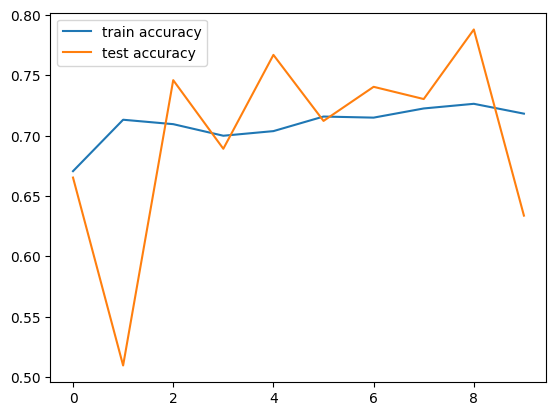

In [ ]:
# Plot losses
plt.plot(history_ResNet50.history['loss'], label="train loss")
plt.plot(history_ResNet50.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history_ResNet50.history['accuracy'], label="train accuracy")
plt.plot(history_ResNet50.history[ 'val_accuracy'], label="test accuracy")
plt.legend()
plt.show()

In [ ]:
# result of Test set
score_ResNet_test = model_ResNet50.evaluate_generator(val_generator)
print('Test loss:', score_ResNet_test[0])
print('Test accuracy:', score_ResNet_test[1])


<ipython-input-51-600e73f6f370>:2: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Test loss: 2.4166111946105957
Test accuracy: 0.6336109638214111


In [ ]:
# result of Train Set
score_ResNet_train = model_ResNet50.evaluate_generator(train_generator)
print('Train loss:', score_ResNet_train[0])
print('Train accuracy:', score_ResNet_train[1])

<ipython-input-42-bbf2d2839417>:2: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Test loss: 2.4266762733459473
Test accuracy: 0.6321654915809631


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_pred = model_ResNet50.predict(val_generator)

# Convert predictions and true labels to categorical labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = val_generator.classes

# Compute confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices, yticklabels=val_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



556/556 [==============================] - 174s 312ms/step


AttributeError: 'DataFrame' object has no attribute 'class_indices'

In [ ]:
# Convert to Pandas Series
y_pred_series = pd.Series(y_pred_classes)

# Count unique values
unique_counts = y_pred_series.value_counts()

# Print the result
print("Unique counts:")
print(unique_counts)

Unique counts:
2     3142
39    1080
10     630
14     626
0      553
3      537
5      390
6      384
36     314
7      219
1      192
11     137
13     133
9      121
18      85
16      80
4       69
8       31
23      27
22      27
12      23
41      23
25      21
17      12
34       6
43       4
40       4
20       3
19       2
30       2
38       2
35       2
28       1
15       1
44       1
dtype: int64


In [ ]:
# Print classification report
#print(classification_report(y_true_classes, y_pred_classes, target_names=data['subCategory'].unique()))
#val_generator
cf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=classes,
                      yticklabels=classes,
                      annot=True, fmt='d', color='blue')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')

Text(0.5, 1.0, 'Confusion matrix of model')

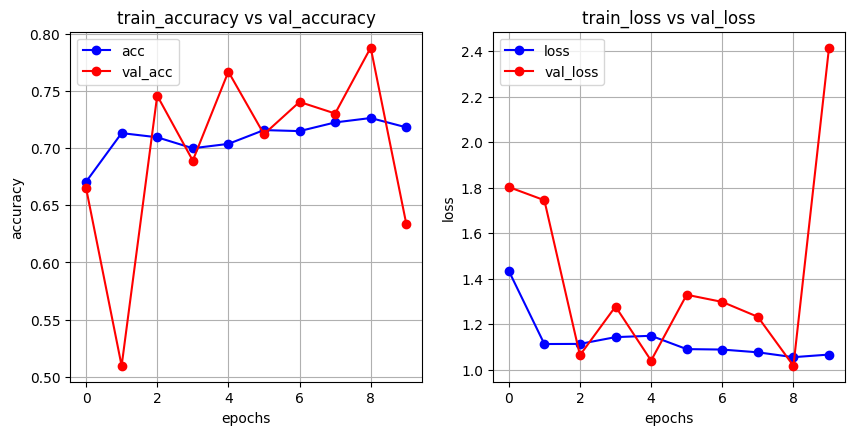

In [ ]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(history_ResNet50.history['accuracy'],'bo-', label = "acc")
plt.plot(history_ResNet50.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history_ResNet50.history['loss'],'bo-', label = "loss")
plt.plot(history_ResNet50.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()


# train model Inception


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_model_inception(name):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='leaky_relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes_data, activation='softmax')(x)

    model = Model(name=name, inputs=base_model.input, outputs=predictions)

    return model

In [ ]:
import time
NAME = "Inception-{}".format(int(time.time()))
model_Inception = build_model_inception(NAME)
model_Inception.summary()
lr = 0.01
epochs = 10

model_Inception.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])


Model: "Inception-1704655961"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_96 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_nor

In [ ]:
history_Inception = model_Inception.fit_generator(train_generator,
                    validation_data = val_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = val_generator.n//val_generator.batch_size,
                    epochs=epochs,
                    )

<ipython-input-36-aab77a58651e>:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
  2/555 [..............................] - ETA: 2:13:27 - loss: 3.6916 - accuracy: 0.3750

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(history_Inception.history['accuracy'],'bo-', label = "acc")
plt.plot(history_Inception.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history_Inception.history['loss'],'bo-', label = "loss")
plt.plot(history_Inception.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_pred = model_Inception.predict(val_generator)

# Convert predictions and true labels to categorical labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = val_generator.classes

# Compute confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices, yticklabels=val_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
#print(classification_report(y_true_classes, y_pred_classes, target_names=val_generator.class_indices.keys()))


In [ ]:
# result of Train Set
score_Inception_train = model_Inception.evaluate_generator(train_generator)
print('Train loss:', score_Inception_train[0])
print('tain accuracy:', score_Inception_train[1])

In [ ]:
# result of Train Set
score_Inception_test = model_Inception.evaluate_generator(val_generator)
print('Train loss:', score_Inception_test[0])
print('tain accuracy:', score_Inception_test[1])

## New Section

##  Pre-trained VGG16
- We will extract the features of the image using the pre-trained deep neural VGG16 network
- We will extract the final features of the network by using global average pooling on the final convolutional block of the network

In [ ]:
base_model = VGG16(include_top=False,input_shape=(224,224,3))

model = Sequential()
for layer in base_model.layers:
    model.add(layer)
model.add(GlobalAveragePooling2D())
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

### Extracting Features of Training and Validation Set

In [ ]:
train_features_vgg = model.predict(train_generator,verbose=1)
val_features_vgg = model.predict(val_generator,verbose=1)


278/278 [==============================] - 190s 685ms/step


## Pre-trained ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load ResNet50 with pre-trained weights
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 23534592 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


### Extracting Features of Training and Validation Set

In [ ]:
train_features_resnet = model.predict(train_generator,verbose=1)
val_features_resnet = model.predict(val_generator,verbose=1)


278/278 [==============================] - 202s 728ms/step


# Dimensionality Reduction for VGG16
- The features extracted using the VGG16 Network product a vector of 512 features. So if we have lets say 10000 products the matrix of our data will be of the dimension 10000 x 512
- Lets see if we can reduce the dimension of this matrix
- For a linear projection based dimensionality reduction method to work there should be high correlation amongst the features
- But to visualize a correlation coeff table of such a high dimensional matrix will be highly resource utilizing
- Lets perform the PCA and see the variance explaination of the principal components to check if our linear projection approach works

In [ ]:
from sklearn.decomposition import PCA


## Illustration of how PCA finds the axes where the within data variability will be maximum
- Lets proceed with 2 principal components first so that we can visualize them in 2D
- We will then look at the Cumulative Variance Explanation to find the right amount of principal components

<img src="https://miro.medium.com/max/1400/1*37a_i1t1tDxDYT3ZI6Yn8w.gif">

In [ ]:
pca = PCA(2)
pca.fit(train_features_vgg)
train_pca_vgg = pca.transform(train_features_vgg)
test_pca_vgg = pca.fit_transform(val_features_vgg)

In [ ]:
train_pca_vgg = pd.DataFrame(train_pca_vgg)
train = train.iloc[:,0:10]
train_vgg = train.merge(train_pca_vgg, how='left', left_index=True, right_index=True)


# Visualization: Principal Components

In [ ]:
fig = px.scatter(train, x=0, y=1, color="masterCategory", title='Main Category', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [ ]:
fig = px.scatter(train, x=0, y=1, color="gender", title='Gender', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [ ]:
fig = px.scatter(train, x=0, y=1, color="subCategory", title='Sub Category', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [ ]:
fig = px.scatter(train[train['season'].notna()], x=0, y=1, color="season", title='Season', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

In [ ]:
fig = px.scatter(train[train['usage'].notna()], x=0, y=1, color="usage", title='Usage', height=600, labels={
                     "0": "Principal Component 1",
                     "1": "Principal Component 2"})
fig.show()

**Inference:**
- The 2 principal components show a reasonably good separability in terms of main product categories
- Maybe after taking more principal components the seprability will be more evident

In [ ]:
pca = PCA()
pca.fit(train_features_vgg)
train_pca_vgg = pca.transform(train_features_vgg)
variance_explained = np.cumsum(pca.explained_variance_ratio_)
pcs = range(1,len(variance_explained)+1)


# Reduced Dimensions: 512 -> 313
- First 313 Principal Components explain 99% of the variance in data
- We will reduce the image feature dimensions to 313

In [ ]:
px.line(x = pcs, y = variance_explained, title = 'Principal Components Cumulative Explained Variance', height=600,  labels={
                     "x": "Principal Components",
                     "y": "Explained Variance"})


In [ ]:
val_pca_vgg = pca.fit_transform(val_features_vgg)[:,:313]
val_pca_vgg = pd.DataFrame(val_pca_vgg)
val = val.iloc[:,0:10]
val = val.merge(val_pca_vgg, how='left', left_index=True, right_index=True)
X_vgg = val.iloc[:,-313:]
y_vgg = val['id']

In [ ]:
X_vgg

0         1         2         3         4         5         6    \
0     1.144056 -0.462432 -0.317373  0.378828 -0.235454  0.134598 -0.254406   
1    -1.316105  1.102871 -0.429451 -0.259928 -0.150694 -0.167041 -0.476243   
2     0.160050  0.407184  0.060160 -0.594245  0.809090 -0.841372  0.916025   
3     1.154053 -0.690968 -0.350718  0.093473  0.439260 -0.604381  1.054487   
4    -1.337911 -0.849140  0.095319 -0.414759  0.018233 -0.037668 -0.272882   
...        ...       ...       ...       ...       ...       ...       ...   
8879  1.623878  0.233822 -0.413102 -0.053969  0.038971 -0.449811 -0.053133   
8880 -1.282373 -1.210945  0.195409 -0.104292  0.020717  0.241684 -0.086276   
8881  0.248953  1.147983  0.327648  0.269476  1.004694 -0.227867  0.249826   
8882 -1.255427  0.839715 -0.697831  0.428212 -0.063543  0.191174 -0.020799   
8883 -0.501413  0.168632 -0.292779 -0.635142  0.129169 -0.331380 -0.058595   

           7         8         9    ...       303       304       305  \
0     0.198058  0.057370 -0.245015  ... -0.031617 -0.022057 -0.031283   
1    -0.441541  0.480841 -0.111190  ...  0.007220  0.012522 -0.020176   
2    -0.355013 -0.603956 -0.450044  ... -0.011666 -0.049515 -0.011065   
3    -0.070872  0.074245 -0.076285  ...  0.000850 -0.022459  0.005310   
4    -0.237126 -0.081440  0.472932  ...  0.003731  0.002094 -0.005320   
...        ...       ...       ...  ...       ...       ...       ...   
8879  0.136835 -0.183942  0.422114  ... -0.002635 -0.011814  0.013307   
8880 -0.333270 -0.057370  0.358353  ...  0.030490 -0.009289  0.023782   
8881  0.014579 -0.246925  0.365094  ... -0.017809  0.038094  0.002811   
8882  0.371109  0.223418 -0.177661  ...  0.048402 -0.036773  0.000345   
8883  0.042685  0.111742 -0.401605  ... -0.005484 -0.018917 -0.008171   

           306       307       308       309       310       311       312  
0    -0.028063 -0.009803 -0.013021  0.013207  0.002694 -0.002363  0.040320  
1    -0.003179 -0.021995  0.002337  0.030795 -0.005090 -0.013064 -0.004569  
2    -0.026783  0.000464  0.013318 -0.041216 -0.046876  0.030619  0.018747  
3     0.046452 -0.005984 -0.015488  0.050289  0.057875 -0.045961 -0.011162  
4    -0.019349  0.016365 -0.004387  0.016922  0.008623  0.037783 -0.009301  
...        ...       ...       ...       ...       ...       ...       ...  
8879  0.016697 -0.008878  0.011880 -0.045889  0.029343 -0.018589  0.015833  
8880  0.039935  0.033010 -0.027044 -0.004677  0.022824  0.021462  0.005369  
8881 -0.018681  0.022725 -0.035865  0.045602  0.002407  0.005687 -0.039351  
8882 -0.031640 -0.045627  0.028913  0.023533  0.034377  0.009866 -0.008072  
8883  0.022991  0.012273  0.022357  0.017106 -0.033159 -0.020379 -0.009175  

[8884 rows x 313 columns]

# K-Nearest Neighbours with VGG
- Lets use k=6, to recommend 6 most similar looking products
- We choose 6 because the first product out of the 6 similar looking products will be the query product itself
- Therefore we can now look at the 5 most similar products based on raw extracted features from the pre-trained network
- We will not use the predict method for classification prediction, but the KNeighbours method to find the k or 6 most nearest neighbours which have visually similar content
- The evaluation of such recommendation techniques is usually done using something like hit-rate, which is an indicator of if the user bought the product recommended to them

In [ ]:
train_pca = pca.fit_transform(train_features_vgg)[:,:313]
train_pca = pd.DataFrame(train_pca)
train_new = train.iloc[:,0:10]
train_new = train.merge(train_pca, how='left', left_index=True, right_index=True)

unique_types = train_new['articleType'].unique().tolist()
total_class = len(unique_types)
print(total_class)
print(unique_types)
print(unique_types[0])
print(unique_types.index(unique_types[0]))
train_new['number_types'] = train_new['articleType'].apply(lambda x: unique_types.index(x) if x in unique_types else 0)
train_new.head(10)
y_vgg = train_new['number_types']

X_vgg = train_new.iloc[:,-313:]


140
['Flats', 'Tshirts', 'Tops', 'Handbags', 'Pendant', 'Sports Shoes', 'Sunglasses', 'Casual Shoes', 'Belts', 'Lip Gloss', 'Watches', 'Kurtas', 'Clutches', 'Heels', 'Ties', 'Deodorant', 'Wallets', 'Backpacks', 'Kurtis', 'Briefs', 'Trunk', 'Bra', 'Churidar', 'Capris', 'Jeans', 'Shirts', 'Shorts', 'Dresses', 'Formal Shoes', 'Flip Flops', 'Earrings', 'Sweaters', 'Cufflinks', 'Perfume and Body Mist', 'Sandals', 'Rompers', 'Leggings', 'Camisoles', 'Lipstick', 'Duffel Bag', 'Sweatshirts', 'Socks', 'Necklace and Chains', 'Trousers', 'Night suits', 'Mobile Pouch', 'Jewellery Set', 'Innerwear Vests', 'Ring', 'Free Gifts', 'Hair Colour', 'Jackets', 'Scarves', 'Sarees', 'Mask and Peel', 'Nail Polish', 'Sports Sandals', 'Accessory Gift Set', 'Kajal and Eyeliner', 'Dupatta', 'Bracelet', 'Tunics', 'Foundation and Primer', 'Lip Care', 'Nightdress', 'Caps', 'Lip Liner', 'Face Moisturisers', 'Skirts', 'Bath Robe', 'Compact', 'Suspenders', 'Salwar', 'Booties', 'Track Pants', 'Baby Dolls', 'Tracksuits',

In [ ]:
# Remove 'number_types' column from X
X_vgg = X_vgg.drop('number_types', axis=1)
# Assume you want to change the name of the column 'old_name' to 'new_name'
X_vgg = X_vgg.rename(columns={'1_y': '1'})
X_vgg

1         2         3         4         5         6         7    \
0     -0.442901 -0.510997 -0.147758  0.517061 -0.117159  0.020608 -0.429533   
1      0.354492 -0.165085 -0.320104  0.478665  0.171327 -0.277206 -0.031660   
2      0.083479 -0.074744 -0.030079  0.741049  0.117276 -0.145907 -0.265015   
3     -0.734597  0.597116 -0.116195 -0.249192 -0.554360  0.119318 -0.357249   
4      0.757834  0.713251 -0.631979 -0.115111 -0.243370 -0.264139 -0.227520   
...         ...       ...       ...       ...       ...       ...       ...   
35530  0.180924 -1.011033  0.469230  0.246310  0.131664  0.319072  0.192442   
35531 -0.614673 -0.428134  0.527986  0.340220  0.066727 -0.534327  0.803360   
35532 -0.524749  0.367020  0.880527 -0.253466 -0.277020 -0.411077 -0.233415   
35533 -0.198349 -0.250902 -0.094164  0.049638  0.214731  0.024731 -0.537646   
35534 -0.017166 -0.126980  0.000268  0.346092  0.202522  0.210000 -0.541328   

            8         9         10   ...       303       304       305  \
0     -0.187542 -0.031754  0.088299  ... -0.029660  0.022994 -0.000640   
1      0.452438 -0.179890  0.181369  ... -0.019709  0.016871 -0.024955   
2      0.068406 -0.371209 -0.058237  ... -0.010270  0.035504  0.022698   
3     -0.098788  0.406228  0.313963  ...  0.020338  0.063711 -0.026603   
4      0.670483 -0.193103  0.245552  ...  0.000057 -0.002449 -0.021685   
...         ...       ...       ...  ...       ...       ...       ...   
35530  0.344156 -0.071134  0.155105  ...  0.001464  0.041790 -0.004139   
35531  0.143827 -0.321802 -0.139329  ...  0.012501  0.002760  0.000427   
35532  0.098064  0.636436  0.397164  ... -0.002614 -0.002200  0.034832   
35533  0.049960 -0.074351 -0.020393  ... -0.004385 -0.012428 -0.026102   
35534  0.446656  0.313125 -0.185955  ... -0.002955 -0.014437 -0.058633   

            306       307       308       309       310       311       312  
0     -0.026156 -0.027741  0.041207 -0.016188  0.020191 -0.009866  0.001950  
1     -0.005643  0.018617 -0.027612 -0.023402 -0.017866  0.004234  0.001782  
2     -0.005313  0.006568  0.024254  0.012690  0.002276  0.011477  0.010168  
3     -0.024548 -0.015095  0.063432  0.014388  0.017990  0.040358  0.014001  
4     -0.024691 -0.058146  0.016293 -0.030473 -0.026208  0.007788 -0.025860  
...         ...       ...       ...       ...       ...       ...       ...  
35530 -0.078892 -0.019130 -0.006624  0.041989 -0.033293 -0.000188  0.003021  
35531 -0.041025 -0.003448 -0.033208 -0.035339 -0.010888  0.053768 -0.019240  
35532 -0.051564 -0.012650 -0.004003 -0.019509 -0.017133 -0.025910  0.014585  
35533 -0.016476  0.014752 -0.040442 -0.000217  0.038046 -0.030575  0.031089  
35534  0.060105  0.014583  0.035997 -0.028577 -0.056468 -0.019637  0.003440  

[35535 rows x 312 columns]

evaluation

In [ ]:
# for test
val_pca = pca.fit_transform(val_features_vgg)[:,:313]
val_pca = pd.DataFrame(val_pca)
val = val.iloc[:,0:10]
val = val.merge(val_pca, how='left', left_index=True, right_index=True)

unique_types = val['articleType'].unique().tolist()
total_class = len(unique_types)
print(total_class)
print(unique_types)
print(unique_types[0])
print(unique_types.index(unique_types[0]))
val['number_types'] = val['articleType'].apply(lambda x: unique_types.index(x) if x in unique_types else 0)
val.head(10)
X_test_vgg = val.iloc[:,-313:]
y_test_vgg = val['number_types']
# Remove 'number_types' column from X
X_test_vgg = X_test_vgg.drop('number_types', axis=1)
X_test_vgg
# Convert feature names to strings
X_test_vgg.columns = X_test_vgg.columns.astype(str)

127
['Tshirts', 'Wallets', 'Tops', 'Casual Shoes', 'Flats', 'Kurtas', 'Watches', 'Shirts', 'Nail Polish', 'Sports Shoes', 'Shorts', 'Jeans', 'Trousers', 'Tunics', 'Bra', 'Sunglasses', 'Innerwear Vests', 'Backpacks', 'Belts', 'Jewellery Set', 'Stockings', 'Sandals', 'Sports Sandals', 'Handbags', 'Briefs', 'Heels', 'Kurtis', 'Cufflinks', 'Sarees', 'Skirts', 'Patiala', 'Socks', 'Flip Flops', 'Earrings', 'Stoles', 'Hair Colour', 'Ring', 'Compact', 'Deodorant', 'Jackets', 'Waistcoat', 'Capris', 'Formal Shoes', 'Mobile Pouch', 'Caps', 'Sweaters', 'Track Pants', 'Laptop Bag', 'Clutches', 'Perfume and Body Mist', 'Lip Liner', 'Headband', 'Ties', 'Kajal and Eyeliner', 'Travel Accessory', 'Duffel Bag', 'Night suits', 'Accessory Gift Set', 'Shoe Accessories', 'Trunk', 'Lipstick', 'Nightdress', 'Lip Gloss', 'Bangle', 'Pendant', 'Lounge Pants', 'Face Moisturisers', 'Baby Dolls', 'Dresses', 'Mascara', 'Free Gifts', 'Necklace and Chains', 'Kurta Sets', 'Sweatshirts', 'Dupatta', 'Mufflers', 'Rain Jack

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
# Convert feature names to strings
#X.columns = X.columns.astype(str)

#scaler = StandardScaler()
#X = scaler.fit_transform(train_features_vgg)
#X_test = scaler.transform(val_features_vgg)

neigh_vgg = KNeighborsClassifier(n_neighbors=6)
neigh_vgg.fit(X_vgg, y_vgg)

y_pred_vgg = neigh_vgg.predict(X_test_vgg) # Predicting

# Assuming you have a separate X_test and y_test for evaluation
y_pred_real_vgg = neigh_vgg.predict(X_vgg)

# Evaluate accuracy for test
accuracy_vgg = accuracy_score(y_test_vgg, y_pred_vgg)
print(f'Accuracy for test: {accuracy_vgg}')

# Evaluate accuracy for train
accuracy_vgg = accuracy_score(y_vgg, y_pred_real_vgg )
print(f'Accuracy for train: {accuracy_vgg}')
# Display classification report
#print('\nClassification Report:')
#print(classification_report(y_test, y_pred))
# Display confusion matrix
#print('\nConfusion Matrix:')
#print(confusion_matrix(y_test, y_pred_vgg))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Accuracy for test: 0.03320576316974336
Accuracy for train: 0.8744336569579289


In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from math import sqrt

# Calculate MSE for train
mse_train_vgg = mean_squared_error(y_vgg, y_pred_real_vgg)
print(f'Mean Squared Error (Train): {mse_train_vgg}')

# Calculate RMSE for train
rmse_train_vgg = sqrt(mse_train_vgg)
print(f'Root Mean Squared Error (Train): {rmse_train_vgg}')

# Calculate MSE for test
mse_test_vgg = mean_squared_error(y_test_vgg, y_pred_vgg)
print(f'Mean Squared Error (Test): {mse_test_vgg}')

# Calculate RMSE for test
rmse_test_vgg = sqrt(mse_test)
print(f'Root Mean Squared Error (Test): {rmse_test_vgg}')


Mean Squared Error (Train): 143.8545940621922
Root Mean Squared Error (Train): 11.99393988905198
Mean Squared Error (Test): 589.4747861323729
Root Mean Squared Error (Test): 21.8731170798296


# K-Nearest Neighbours with Resnet50

In [ ]:
train_pca = pca.fit_transform(train_features_resnet)[:,:313]
train_pca = pd.DataFrame(train_pca)
train_new = train.iloc[:,0:10]
train_new = train.merge(train_pca, how='left', left_index=True, right_index=True)

unique_types = train_new['articleType'].unique().tolist()
total_class = len(unique_types)
print(total_class)
print(unique_types)
print(unique_types[0])
print(unique_types.index(unique_types[0]))
train_new['number_types'] = train_new['articleType'].apply(lambda x: unique_types.index(x) if x in unique_types else 0)
train_new.head(10)
y_resnet = train_new['number_types']

X_resnet = train_new.iloc[:,-313:]


140
['Flats', 'Tshirts', 'Tops', 'Handbags', 'Pendant', 'Sports Shoes', 'Sunglasses', 'Casual Shoes', 'Belts', 'Lip Gloss', 'Watches', 'Kurtas', 'Clutches', 'Heels', 'Ties', 'Deodorant', 'Wallets', 'Backpacks', 'Kurtis', 'Briefs', 'Trunk', 'Bra', 'Churidar', 'Capris', 'Jeans', 'Shirts', 'Shorts', 'Dresses', 'Formal Shoes', 'Flip Flops', 'Earrings', 'Sweaters', 'Cufflinks', 'Perfume and Body Mist', 'Sandals', 'Rompers', 'Leggings', 'Camisoles', 'Lipstick', 'Duffel Bag', 'Sweatshirts', 'Socks', 'Necklace and Chains', 'Trousers', 'Night suits', 'Mobile Pouch', 'Jewellery Set', 'Innerwear Vests', 'Ring', 'Free Gifts', 'Hair Colour', 'Jackets', 'Scarves', 'Sarees', 'Mask and Peel', 'Nail Polish', 'Sports Sandals', 'Accessory Gift Set', 'Kajal and Eyeliner', 'Dupatta', 'Bracelet', 'Tunics', 'Foundation and Primer', 'Lip Care', 'Nightdress', 'Caps', 'Lip Liner', 'Face Moisturisers', 'Skirts', 'Bath Robe', 'Compact', 'Suspenders', 'Salwar', 'Booties', 'Track Pants', 'Baby Dolls', 'Tracksuits',

In [ ]:
# Remove 'number_types' column from X
X_resnet= X_resnet.drop('number_types', axis=1)
# Assume you want to change the name of the column 'old_name' to 'new_name'
X_resnet = X_resnet.rename(columns={'1_y': '1'})
X_resnet

1         2         3         4         5         6         7    \
0     -1.595142  0.269889 -0.027386  0.126163 -0.541376 -0.241240  0.128094   
1      1.740745  0.653239  0.111100 -0.766437  0.181587  0.752824  0.259167   
2      1.027605 -0.697418  0.306458 -0.504507 -0.033485  0.006633  0.089097   
3      2.554922 -1.554979 -0.268296  0.150300  0.110941 -0.497237  0.181575   
4      0.121080  1.961545  0.090424 -0.832113  0.483386  0.638731 -0.432864   
...         ...       ...       ...       ...       ...       ...       ...   
35530 -1.670455 -0.315067 -0.582808  0.213775  0.027806  0.209598  0.039144   
35531  1.691292 -1.206997 -0.908985 -0.492255 -0.016085 -0.429950 -0.136700   
35532  1.858446 -0.065462  3.824351  1.173318  0.044814  0.045432  0.634349   
35533  2.336665  0.379632  0.465995 -0.482832 -0.580262 -0.331031 -0.210911   
35534  0.682254 -0.406900  0.234230 -0.193071 -0.195843 -0.116736 -0.232151   

            8         9         10   ...       303       304       305  \
0     -0.310588  0.079702  0.055571  ... -0.009418  0.005603  0.007129   
1      0.042667 -0.482386 -0.406359  ...  0.024900  0.000463 -0.003851   
2     -0.086970 -0.123672  0.325765  ...  0.005119  0.000144 -0.004859   
3      0.003128  0.545650 -0.800041  ... -0.016315  0.014598 -0.025744   
4     -0.199883  0.597198 -0.673333  ...  0.015097 -0.029563  0.008036   
...         ...       ...       ...  ...       ...       ...       ...   
35530 -0.061579  0.235647  0.012302  ... -0.001429 -0.004792 -0.002381   
35531  0.168106 -0.398237  0.209742  ...  0.011388  0.000452 -0.024351   
35532  0.182242  0.355513  0.289525  ...  0.036259 -0.038151 -0.006196   
35533 -0.336196  0.325138  0.214421  ...  0.006435  0.008726 -0.003666   
35534 -0.258401  0.088274  0.180875  ... -0.000145  0.001503 -0.011514   

            306       307       308       309       310       311       312  
0     -0.008404 -0.016867  0.004163 -0.017490  0.016835  0.005179  0.001423  
1     -0.006469  0.018344  0.013402  0.004788 -0.006095  0.009879 -0.010243  
2      0.011739 -0.002113  0.010000 -0.012504 -0.006504 -0.008949 -0.002558  
3     -0.004720  0.002653  0.001626 -0.013476  0.026716  0.003629 -0.017763  
4      0.009288  0.015766  0.033382  0.026425 -0.017983  0.007861 -0.003714  
...         ...       ...       ...       ...       ...       ...       ...  
35530 -0.001588 -0.010766  0.005872  0.000494 -0.008796  0.006305 -0.000080  
35531 -0.008120 -0.007919  0.006133 -0.002753 -0.007444  0.011764 -0.009868  
35532 -0.004276  0.010903  0.006755 -0.022523  0.023196  0.012355 -0.014017  
35533  0.003599  0.017685  0.005595 -0.014768  0.001274  0.022099 -0.013222  
35534 -0.007040 -0.002684 -0.007954 -0.014565 -0.001095 -0.016856 -0.008264  

[35535 rows x 312 columns]

In [ ]:
# for test
val_pca = pca.fit_transform(val_features_resnet)[:,:313]
val_pca = pd.DataFrame(val_pca)
val = val.iloc[:,0:10]
val = val.merge(val_pca, how='left', left_index=True, right_index=True)

unique_types = val['articleType'].unique().tolist()
total_class = len(unique_types)
print(total_class)
print(unique_types)
print(unique_types[0])
print(unique_types.index(unique_types[0]))
val['number_types'] = val['articleType'].apply(lambda x: unique_types.index(x) if x in unique_types else 0)
val.head(10)
X_test_resnet = val.iloc[:,-313:]
y_test_resnet = val['number_types']
# Remove 'number_types' column from X
X_test_resnet = X_test_resnet.drop('number_types', axis=1)
X_test_resnet
# Convert feature names to strings
X_test_resnet.columns = X_test_resnet.columns.astype(str)


127
['Tshirts', 'Wallets', 'Tops', 'Casual Shoes', 'Flats', 'Kurtas', 'Watches', 'Shirts', 'Nail Polish', 'Sports Shoes', 'Shorts', 'Jeans', 'Trousers', 'Tunics', 'Bra', 'Sunglasses', 'Innerwear Vests', 'Backpacks', 'Belts', 'Jewellery Set', 'Stockings', 'Sandals', 'Sports Sandals', 'Handbags', 'Briefs', 'Heels', 'Kurtis', 'Cufflinks', 'Sarees', 'Skirts', 'Patiala', 'Socks', 'Flip Flops', 'Earrings', 'Stoles', 'Hair Colour', 'Ring', 'Compact', 'Deodorant', 'Jackets', 'Waistcoat', 'Capris', 'Formal Shoes', 'Mobile Pouch', 'Caps', 'Sweaters', 'Track Pants', 'Laptop Bag', 'Clutches', 'Perfume and Body Mist', 'Lip Liner', 'Headband', 'Ties', 'Kajal and Eyeliner', 'Travel Accessory', 'Duffel Bag', 'Night suits', 'Accessory Gift Set', 'Shoe Accessories', 'Trunk', 'Lipstick', 'Nightdress', 'Lip Gloss', 'Bangle', 'Pendant', 'Lounge Pants', 'Face Moisturisers', 'Baby Dolls', 'Dresses', 'Mascara', 'Free Gifts', 'Necklace and Chains', 'Kurta Sets', 'Sweatshirts', 'Dupatta', 'Mufflers', 'Rain Jack

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
#scaler = StandardScaler()
#X = scaler.fit_transform(train_features_vgg)
#X_test = scaler.transform(val_features_vgg)

neigh_resnet = KNeighborsClassifier(n_neighbors=6)
neigh_resnet.fit(X_resnet, y_resnet)

y_pred_resnet = neigh_resnet.predict(X_test_resnet) # Predicting

# Assuming you have a separate X_test and y_test for evaluation
y_pred_real_resnet = neigh_resnet.predict(X_resnet)

# Evaluate accuracy for test
accuracy_resnet = accuracy_score(y_test_resnet, y_pred_resnet)
print(f'Accuracy for test: {accuracy_resnet}')

# Evaluate accuracy for train
accuracy_resnet = accuracy_score(y_resnet, y_pred_real_resnet )
print(f'Accuracy for train: {accuracy_resnet}')
# Display classification report
#print('\nClassification Report:')
#print(classification_report(y_test, y_pred))
# Display confusion matrix
#print('\nConfusion Matrix:')
#print(confusion_matrix(y_test, y_pred_vgg))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Accuracy for test: 0.013732552904097254
Accuracy for train: 0.7819051639228929


In [ ]:
# resnet
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from math import sqrt

# Assuming you have y_train and y_test for evaluation
#y_train_pred = neigh_resnet.predict(X)

# Calculate MSE for train
mse_train_resnet = mean_squared_error(y_resnet, y_pred_real_resnet )
print(f'Mean Squared Error (Train): {mse_train_resnet}')

# Calculate RMSE for train
rmse_train_resnet = sqrt(mse_train_resnet)
print(f'Root Mean Squared Error (Train): {rmse_train_resnet}')

# Calculate MSE for test
mse_test_resnet = mean_squared_error(y_test_resnet, y_pred_resnet)
print(f'Mean Squared Error (Test): {mse_test_resnet}')

# Calculate RMSE for test
rmse_test_resnet = sqrt(mse_test_resnet)
print(f'Root Mean Squared Error (Test): {rmse_test_resnet}')


Mean Squared Error (Train): 248.40970873786407
Root Mean Squared Error (Train): 15.761018645311733
Mean Squared Error (Test): 778.7179198559207
Root Mean Squared Error (Test): 27.905517731372065


# Results
- The results can definitely improved by creating data of similar styled or branded products
- A siamese network can then be trained to create image features where similarly styled or branded products are in closer proximity

In [ ]:
def read_img(image_path):
    image = load_img(image_path,target_size=(256,256,3))
    image = img_to_array(image)
    image = image/255.
    return image

In [ ]:
import random

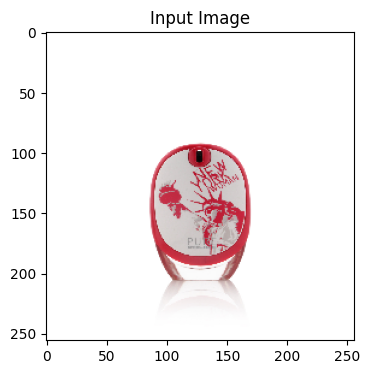

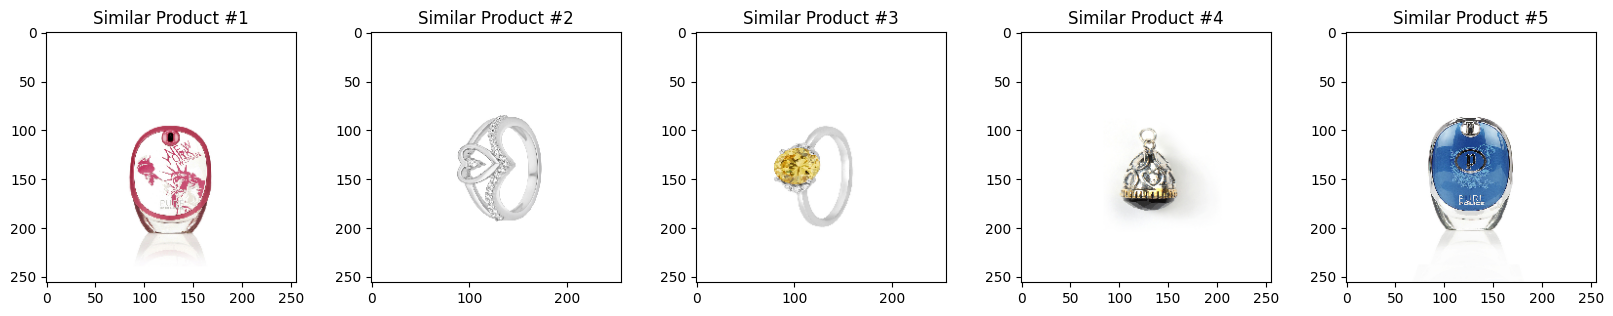

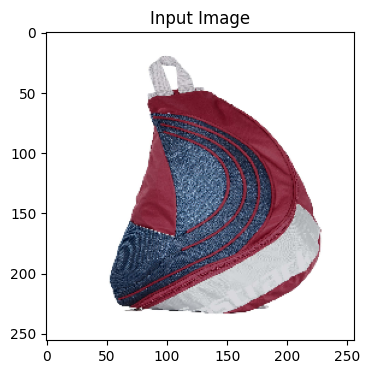

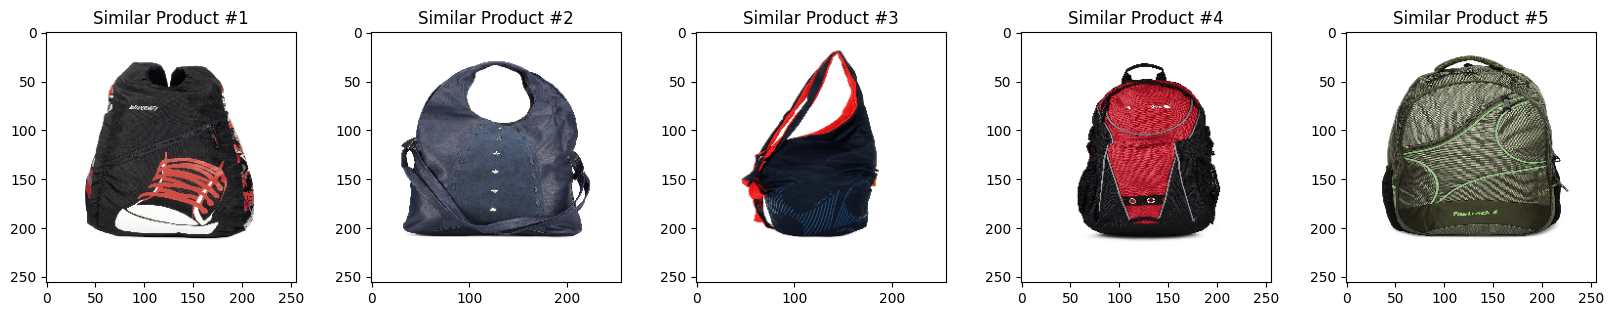

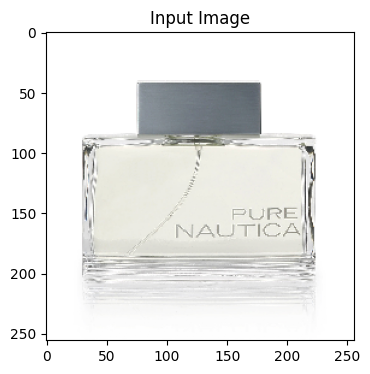

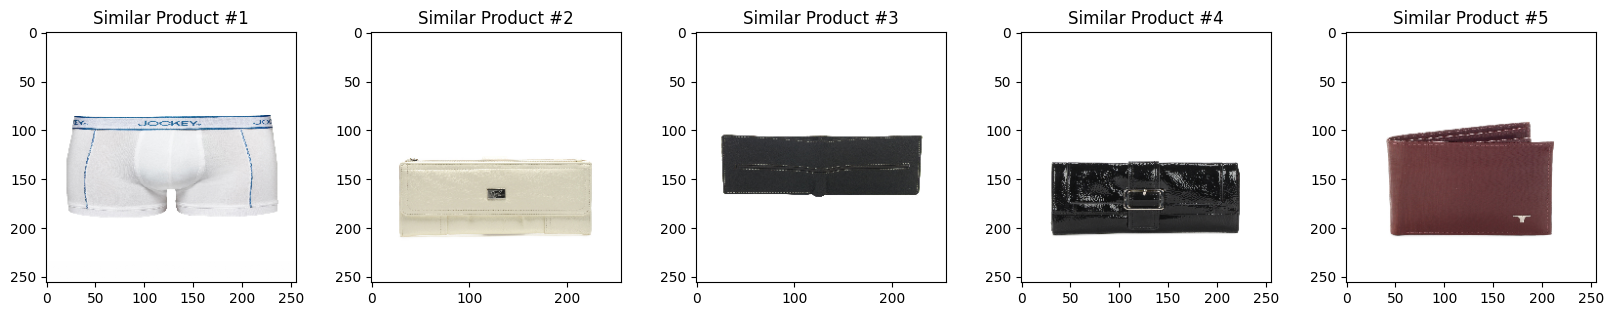

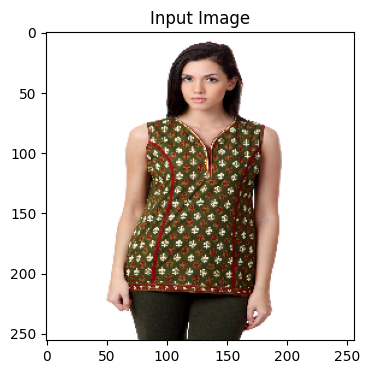

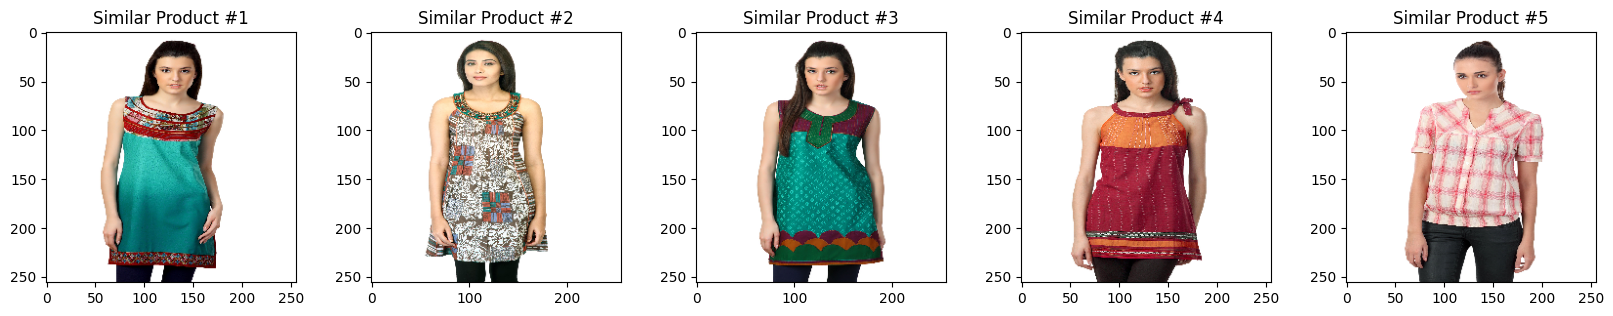

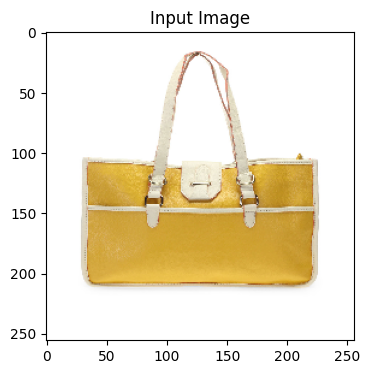

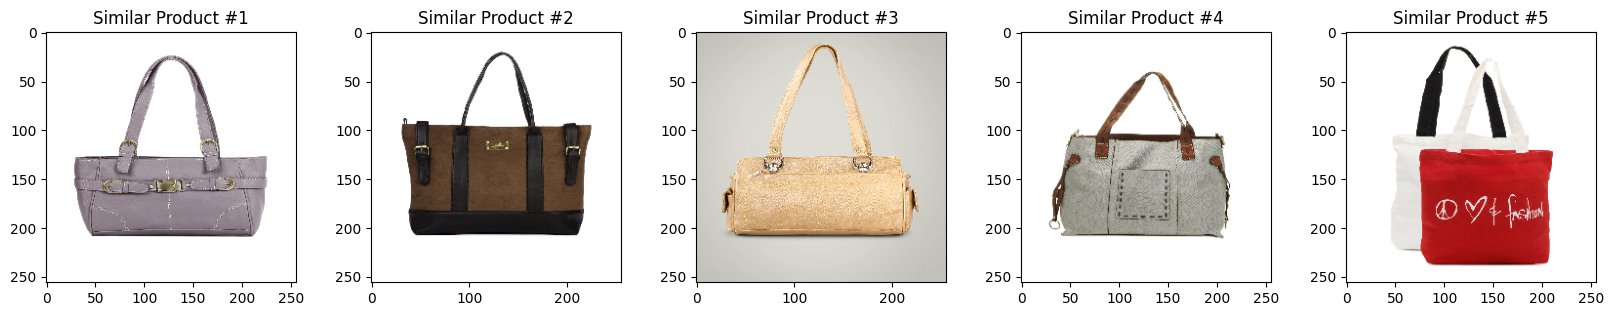

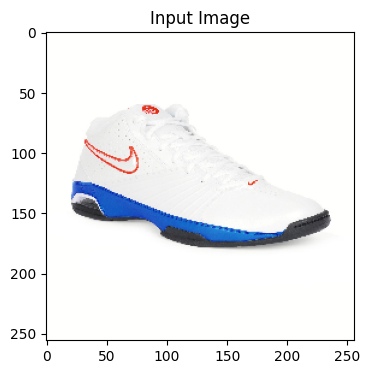

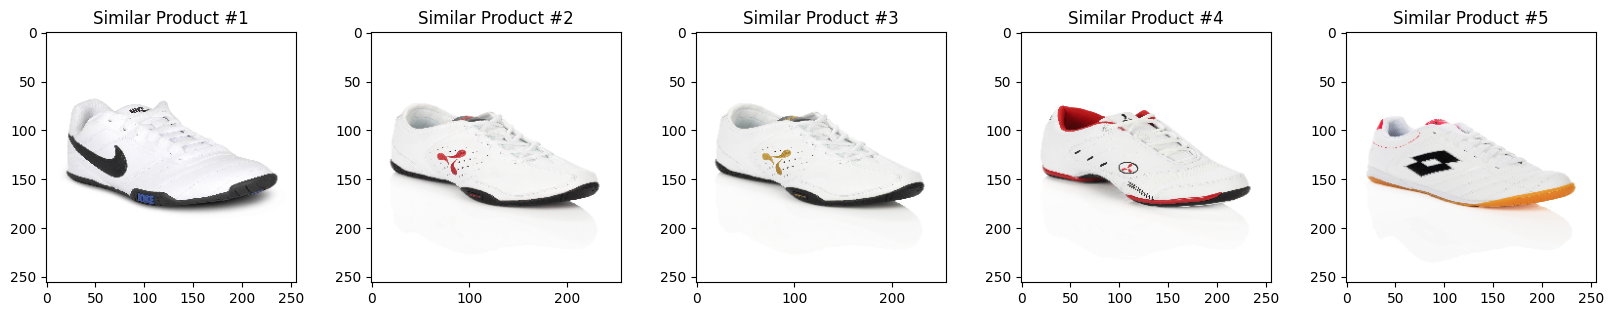

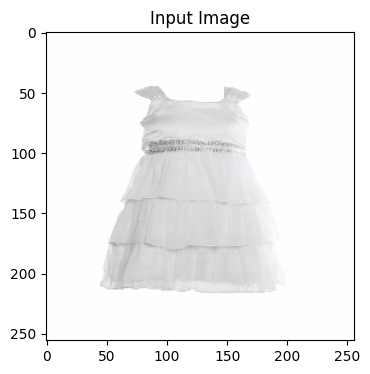

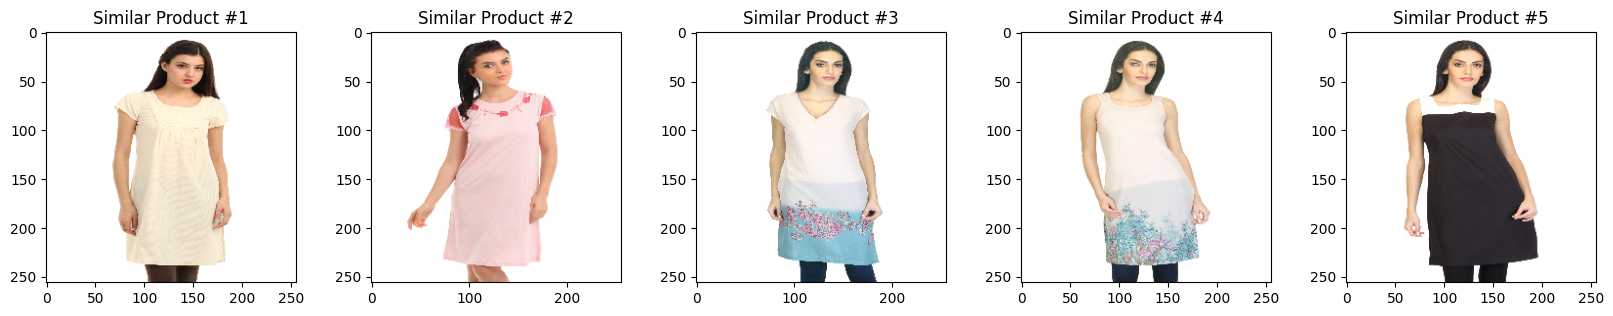

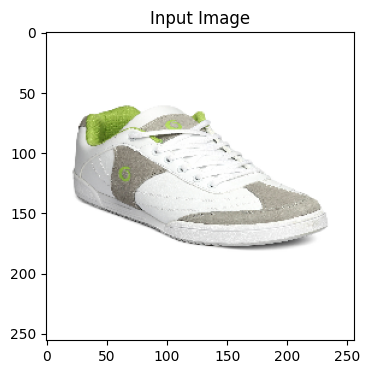

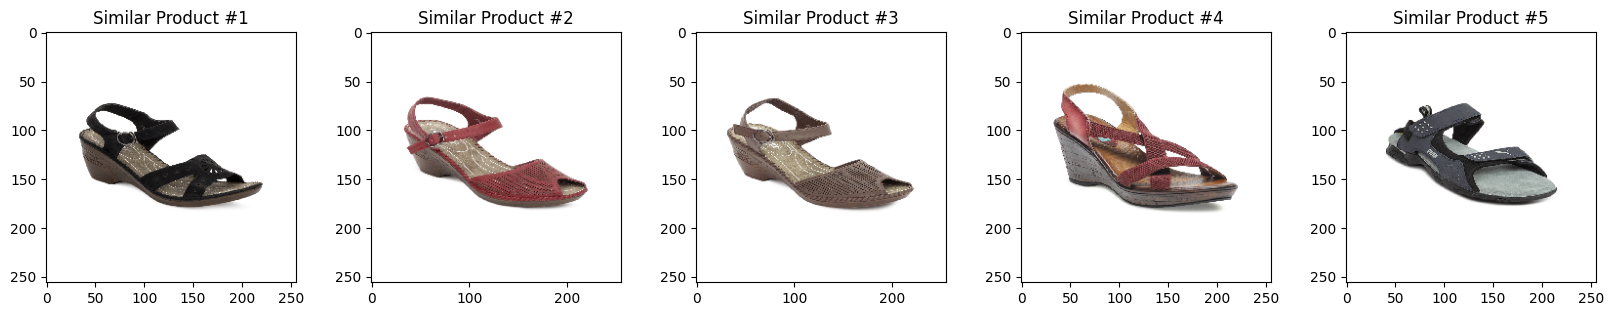

In [ ]:
for _ in range(10):
    i = random.randint(1,len(val))
    img1 = read_img(val.loc[i,'filename'])
    dist, index = neigh.kneighbors(X=X.iloc[i,:].values.reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(val.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')